In [1]:
import os
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir("/home/stotoshka/Documents/ANGEL_dev")

# Подготовка выборок для обучения

Выполнить скрипт HLA/prepare_HLA_train.R

# Конвертация в SDF

In [ ]:
to_convert_files = glob("HLA/data/train/*_HLA_?.csv")
print(to_convert_files)

In [ ]:
%%time
for file in to_convert_files:
	print(file)
	path_to_config = "HLA/data/converter_config.json"
	command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),file)} -o {os.path.join(os.getcwd(),'HLA/data/sdf')} -c epitope -t 10 {path_to_config}"
	os.system(command)
	print("Convertation")
	convert_command = f"python tools/SeqToSDF.py {path_to_config}"
	os.system(convert_command)

In [ ]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
rm HLA/data/sdf/*.txt
cp HLA/data/sdf/* /run/user/1000/gvfs/smb-share:server=192.168.0.10,share=diplom/ANGEL/HLA/sdf

# Запуск

Осуществлялся вручную в GUI версии PASS

# Обработка результатов

In [ ]:
%%bash
cp /media/stotoshka/22DC267FDC264D7B/Users/Антон/Desktop/diplom/HLA/*_CRV.LOG ~/Documents/ANGEL_dev/HLA/data/results/5CV/internal/
cp /media/stotoshka/22DC267FDC264D7B/Users/Антон/Desktop/diplom/HLA/result/*.CSV ~/Documents/ANGEL_dev/HLA/data/results/5CV/external/

In [ ]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
python HLA/parse5CV.py internal GUI /home/stotoshka/Documents/ANGEL_dev/HLA/data/results/5CV/internal /home/stotoshka/Documents/ANGEL_dev/HLA/data/results/5CV/internal.xlsx
python HLA/parse5CV.py external GUI /home/stotoshka/Documents/ANGEL_dev/HLA/data/results/5CV/external /home/stotoshka/Documents/ANGEL_dev/HLA/data/results/5CV/external.xlsx

# Внутренняя валидация

In [12]:
internal_result = pd.read_excel("HLA/data/results/5CV/internal.xlsx")
internal_result.head()

,model_name,fold,descriptor_level,iap,twentyCV,activity,num_subst
0,HLA,1,8,0.8907,0.8902,HLA-A*02:01,42178
1,HLA,1,8,0.9584,0.9581,HLA-B*07:02,19134
2,HLA,1,8,0.9257,0.9244,HLA-C*03:04,6047
3,HLA,1,8,0.8969,0.8960,HLA-B*27:05,44149
4,HLA,1,8,0.9543,0.9540,HLA-A*11:01,11264


In [13]:
median_results = internal_result.groupby(["fold","descriptor_level"]).agg({"twentyCV":"median"})
median_results.head(20)

twentyCV
fold descriptor_level          
1    2                  0.81115
     3                  0.87550
     4                  0.91435
     5                  0.92950
     6                  0.93630
     7                  0.93620
     8                  0.93300
     9                  0.92580
     10                 0.91440
2    2                  0.81440
     3                  0.87705
     4                  0.91300
     5                  0.93020
     6                  0.93510
     7                  0.93550
     8                  0.93265
     9                  0.92480
     10                 0.91525
3    2                  0.80865
     3                  0.88160

<Axes: title={'center': 'HLA'}, xlabel='Уровень MNA дескрипторов', ylabel='Медиана (AUC ROC 20CV)'>

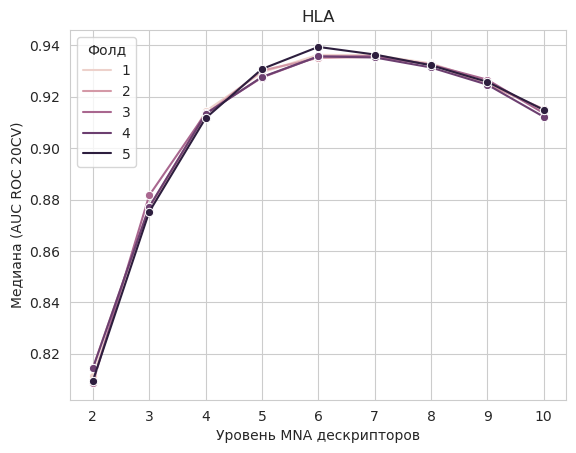

In [15]:
internal_plot = sns.lineplot(x = 'descriptor_level', y = 'twentyCV', data=median_results, hue='fold', marker="o")
plt.xlabel("Уровень MNA дескрипторов")
plt.ylabel("Медиана (AUC ROC 20CV)")
plt.title("HLA")
plt.legend(title = "Фолд")
plt.savefig("HLA/data/results/5CV/plots/median_internal.png")
internal_plot

# Внешняя валидация

In [16]:
external_result = pd.read_excel("HLA/data/results/5CV/external.xlsx")
external_result.head()

,model,level,activity,auc_roc,ap
0,HLA,5,HLA-A*02:01,0.828591,0.354467
1,HLA,5,HLA-B*07:02,0.895524,0.382405
2,HLA,5,HLA-B*51:01,0.889127,0.286736
3,HLA,5,HLA-C*03:04,0.866118,0.121332
4,HLA,5,HLA-A*11:01,0.915680,0.305923


In [17]:
median_results = external_result.groupby(["level"]).agg({"auc_roc":"median","ap":"median"})
median_results.head(20)

,auc_roc,ap
level,,
2,0.764128,0.015474
3,0.833018,0.027150
4,0.874998,0.046109
5,0.895311,0.064422
6,0.897114,0.068389
7,0.893919,0.055129
8,0.882321,0.043723
9,0.868133,0.036468
10,0.852473,0.030306


<Axes: title={'center': 'HLA'}, xlabel='Уровень MNA дескрипторов', ylabel='Медиана (AUC ROC)'>

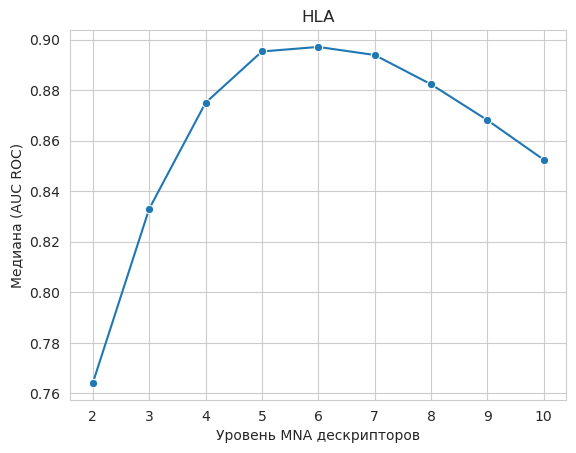

In [18]:
auc_plot = sns.lineplot(x = 'level', y = 'auc_roc', data=median_results, marker="o")
plt.xlabel("Уровень MNA дескрипторов")
plt.ylabel("Медиана (AUC ROC)")
plt.title("HLA")
plt.savefig("HLA/data/results/5CV/plots/median_auc_from_level.png")
auc_plot

<Axes: title={'center': 'HLA'}, xlabel='Уровень MNA дескрипторов', ylabel='Медиана (Average precision)'>

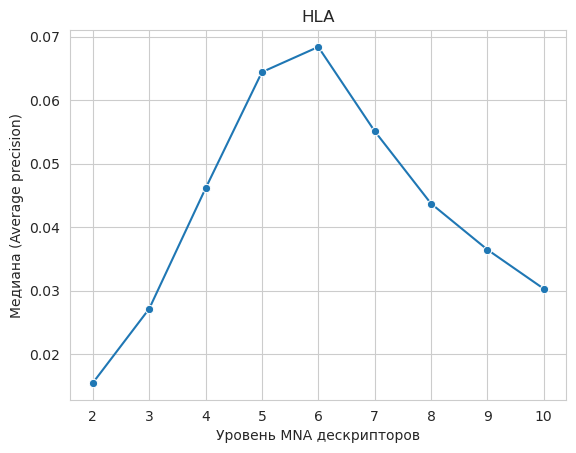

In [19]:
ap_plot = sns.lineplot(x = 'level', y = 'ap', data=median_results, marker="o")
plt.xlabel("Уровень MNA дескрипторов")
plt.ylabel("Медиана (Average precision)")
plt.title("HLA")
plt.savefig("HLA/data/results/5CV/plots/median_ap_from_level.png")
ap_plot